In this notebook we will create a book recommender using a traditional way which is collaborative filtering and a deep learning way which use Tensorflow Recommenders

# Import and Install Library

In [1]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q scann

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.3/89.3 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 118.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 82.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)

# Import data

In [3]:
rating_df = pd.read_csv('https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/ratings.csv')
book_df = pd.read_csv('https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/books.csv')
tags_df = pd.read_csv('https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/book_tags.csv')
tags_dict_df = pd.read_csv('https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/tags.csv')

# Viewing the data

so the author that generete the data have given us a notebook that give us a look at the data, we can for this time look in there. here is the link : https://github.com/zygmuntz/goodbooks-10k/blob/master/quick_look.ipynb

thanks zygmuntz!

When we look at the quick_look,ipynb we can see some interesting data, like "to_read" csv, which is filled with user id and user selected book "to read", it can be use to better our recommender model

but on today we will only focus on the books that have been rated

in the book csv there is also a lot more data we can use, and there is a lot of tags too, but again lets use them on future works

In [4]:
rating_df.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [5]:
rating_df.isna().sum()

user_id    0
book_id    0
rating     0
dtype: int64

In [6]:
book_df.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [7]:
book_df['original_title'].head(20)

0                                      The Hunger Games
1              Harry Potter and the Philosopher's Stone
2                                              Twilight
3                                 To Kill a Mockingbird
4                                      The Great Gatsby
5                                The Fault in Our Stars
6                    The Hobbit or There and Back Again
7                                The Catcher in the Rye
8                                      Angels & Demons 
9                                   Pride and Prejudice
10                                     The Kite Runner 
11                                            Divergent
12                                 Nineteen Eighty-Four
13                           Animal Farm: A Fairy Story
14    Het Achterhuis: Dagboekbrieven 14 juni 1942 - ...
15                                Män som hatar kvinnor
16                                        Catching Fire
17             Harry Potter and the Prisoner of 

In [8]:
book_df['original_title'].unique().shape

(9275,)

In [9]:
book_df.isna().sum()

book_id                         0
goodreads_book_id               0
best_book_id                    0
work_id                         0
books_count                     0
isbn                          700
isbn13                        585
authors                         0
original_publication_year      21
original_title                585
title                           0
language_code                1084
average_rating                  0
ratings_count                   0
work_ratings_count              0
work_text_reviews_count         0
ratings_1                       0
ratings_2                       0
ratings_3                       0
ratings_4                       0
ratings_5                       0
image_url                       0
small_image_url                 0
dtype: int64

TODO :  add viewing TAG data

the data is ready enough, and we will not go straight doing an EDA, cause the quick_look.ipynb is enough to give us the information we need to implement a recommender system out of it

# Utils Functions

In [10]:
def get_book_id(name):
  res = book_df.loc[book_df.original_title == name].book_id
  return res.values[0]

def get_book_name(book_id):
  res = book_df.loc[book_df.book_id == book_id].original_title
  return res.values[0]

# Correlation Method

In [ ]:
book_df[['book_id','original_title']]

,book_id,original_title
0,1,The Hunger Games
1,2,Harry Potter and the Philosopher's Stone
2,3,Twilight
3,4,To Kill a Mockingbird
4,5,The Great Gatsby
...,...,...
9995,9996,Bayou Moon
9996,9997,Means of Ascent
9997,9998,The Mauritius Command
9998,9999,Cinderella Ate My Daughter: Dispatches from th...


In [ ]:
corr_ratings = rating_df.merge(book_df[['book_id','original_title']], on='book_id')

In [ ]:
corr_ratings.head()

,user_id,book_id,rating,original_title
0,1,258,5,La sombra del viento
1,11,258,3,La sombra del viento
2,143,258,4,La sombra del viento
3,242,258,5,La sombra del viento
4,325,258,4,La sombra del viento


In [ ]:
corr_ratings = rating_df.pivot_table(index ='user_id',
              columns ='book_id', values ='rating')

KeyboardInterrupt: ignored

In [ ]:
corr_ratings.shape

In [ ]:
corr_ratings.head()

In [ ]:
book_df.loc[book_df.original_title == "Harry Potter and the Philosopher's Stone"].book_id.values[0]

In [ ]:
def get_book_id(name):
  res = book_df.loc[book_df.original_title == name].book_id
  return res.values[0]

def get_book_name(book_id):
  res = book_df.loc[book_df.book_id == book_id].original_title
  return res.values[0]

In [ ]:
temp_book_name = get_book_name(2)
temp_book_name

In [ ]:
temp_book_id = get_book_id(get_book_name(2))
temp_book_id

In [ ]:
# analysing correlation with similar movies
# cause index start with zero, we must add -1 to the book_id, because index column
# number two is the book Twilight, and harry potter book is index number 1
harry_user_ratings = corr_ratings.iloc[:,temp_book_id-1]
  
harry_user_ratings

In [ ]:
# analysing correlation with similar movies
similar_to_harry = corr_ratings.corrwith(harry_user_ratings)

In [ ]:
corr_harry = pd.DataFrame(similar_to_harry, columns =['Correlation']).sort_values('Correlation', ascending = False)
corr_harry.dropna(inplace = True)
recm_harry = corr_harry.reset_index()
recm_harry['title'] = recm_harry['book_id'].apply(get_book_name) 
recm_harry.head(10)

In [ ]:
def get_recommendation_by_book_name(book_name):
  target_book_id = get_book_id(book_name)
  target_user_ratings = corr_ratings.iloc[:,target_book_id-1]
  similar_to_target = corr_ratings.corrwith(target_user_ratings)

  corr_target = pd.DataFrame(similar_to_target, columns=['Correlation']).sort_values('Correlation', ascending = False)
  corr_target.dropna(inplace = True)
  recm_target = corr_target.reset_index()
  recm_target['title'] = recm_target['book_id'].apply(get_book_name)
  return recm_target['title']

In [ ]:
get_recommendation_by_book_name('Mockingjay')[:10]

# Hybrid Method

so a hybrid method is actually a weighted average on the score

ok kalo di hybrid method itu ada beberapa hal yang mesti gw establish
yang pertama itu formulanya dan apa saja yang mesti gw siapin
so first we are gonna copy that formula we refecen from : https://www.kaggle.com/code/mfaaris/hybrid-and-tensorflow-recommender-system

## Formula Plan

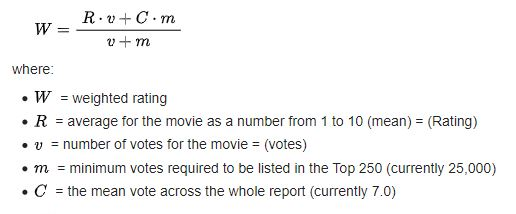

so in here there are a couple of things we can manage to creata and have
and the ones we have are:
- R : AVG Ratings using feature "average_rating"
- v : number of votes using "ratings_count"

thats it? ok so lets code this one and the other ones

for m we make it as the 80% quantile of number of votes (v)

and for C is basilcly the mean of avg ratings, its basiclnya the mean of feature "average_rating", that is a simple explantion of it and also a good one

In [11]:
R = book_df['average_rating']
v = book_df['ratings_count']
m = book_df['ratings_count'].quantile(0.8)
C = book_df['average_rating'].mean()

### Print those values

In [12]:
R

0       4.34
1       4.44
2       3.57
3       4.25
4       3.89
        ... 
9995    4.09
9996    4.25
9997    4.35
9998    3.65
9999    4.00
Name: average_rating, Length: 10000, dtype: float64

In [13]:
v

0       4780653
1       4602479
2       3866839
3       3198671
4       2683664
         ...   
9995      17204
9996      12582
9997       9421
9998      11279
9999       9162
Name: ratings_count, Length: 10000, dtype: int64

In [14]:
m

50089.60000000002

In [15]:
C

4.002191000000001

## Implement the formula

In [16]:
book_df['weighted_average'] = (R*v + C*m)/(v+m)

In [17]:
book_df['weighted_average'].describe()

count    10000.000000
mean         4.005799
std          0.098694
min          3.315159
25%          3.958087
50%          4.007087
75%          4.056095
max          4.593055
Name: weighted_average, dtype: float64

In [18]:
book_df.columns

Index(['book_id', 'goodreads_book_id', 'best_book_id', 'work_id',
       'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year',
       'original_title', 'title', 'language_code', 'average_rating',
       'ratings_count', 'work_ratings_count', 'work_text_reviews_count',
       'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5',
       'image_url', 'small_image_url', 'weighted_average'],
      dtype='object')

## Implement Popularity feature

so as stated in the "quick_look.ipynb" that "Books are sorted by their popularity, as measured by number of ratings (overall, not in this dataset)."

so in maybe a lazy/fast way we can create a value from N - 1 array and put it in the df as "popularity". N being the number of books

UPDATE, instead of scaling using minmax, why not just divide it now by 10000 (number of books)?

In [19]:
book_df['popularity'] = np.arange(book_df.shape[0],0,-1) / book_df.shape[0]

In [20]:
book_df.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,weighted_average,popularity
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,4.336497,1.0000
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,4.435287,0.9999
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,3.575527,0.9998
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...,4.246179,0.9997
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...,3.892056,0.9996


## Scale the features

In [21]:
book_df.columns

Index(['book_id', 'goodreads_book_id', 'best_book_id', 'work_id',
       'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year',
       'original_title', 'title', 'language_code', 'average_rating',
       'ratings_count', 'work_ratings_count', 'work_text_reviews_count',
       'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5',
       'image_url', 'small_image_url', 'weighted_average', 'popularity'],
      dtype='object')

In [22]:
book_weighted_df = book_df[['book_id','authors','original_title','weighted_average', 'popularity']].copy()

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
book_weighted_df['weighted_average'] = scaler.fit_transform(book_weighted_df[['weighted_average']])
book_weighted_df.head()

,book_id,authors,original_title,weighted_average,popularity
0,1,Suzanne Collins,The Hunger Games,0.799234,1.0000
1,2,"J.K. Rowling, Mary GrandPré",Harry Potter and the Philosopher's Stone,0.876541,0.9999
2,3,Stephenie Meyer,Twilight,0.203748,0.9998
3,4,Harper Lee,To Kill a Mockingbird,0.728557,0.9997
4,5,F. Scott Fitzgerald,The Great Gatsby,0.451443,0.9996


## Final Score Value (Popularity vs Weighted Average)

so on the final score we can merge the popularity and weighted average, but on how much. the notebook we are referencing is base on MovieLens data and movie popularity is kinda a powerful thing to recommend someone. so we will assume this goes the same for books. and we will use the same way that the notebook we are referencing, which "Let's take 40% weight for weigthed average and 60% weight for popularity"

by multiplying that percentage and using the + operator to join both values

In [24]:
book_weighted_df['score'] = book_weighted_df['weighted_average']*0.4 + book_weighted_df['popularity']*0.6

In [25]:
book_weighted_df.head()

,book_id,authors,original_title,weighted_average,popularity,score
0,1,Suzanne Collins,The Hunger Games,0.799234,1.0000,0.919694
1,2,"J.K. Rowling, Mary GrandPré",Harry Potter and the Philosopher's Stone,0.876541,0.9999,0.950556
2,3,Stephenie Meyer,Twilight,0.203748,0.9998,0.681379
3,4,Harper Lee,To Kill a Mockingbird,0.728557,0.9997,0.891243
4,5,F. Scott Fitzgerald,The Great Gatsby,0.451443,0.9996,0.780337


In [26]:
book_weighted_df_sorted = book_weighted_df.sort_values(by='score', ascending=False)
book_weighted_df_sorted.head(10)

,book_id,authors,original_title,weighted_average,popularity,score
24,25,"J.K. Rowling, Mary GrandPré",Harry Potter and the Deathly Hallows,1.000000,0.9976,0.998560
26,27,"J.K. Rowling, Mary GrandPré",Harry Potter and the Half-Blood Prince,0.946290,0.9974,0.976956
17,18,"J.K. Rowling, Mary GrandPré, Rufus Beck",Harry Potter and the Prisoner of Azkaban,0.939670,0.9983,0.974848
23,24,"J.K. Rowling, Mary GrandPré",Harry Potter and the Goblet of Fire,0.939184,0.9977,0.974293
421,422,J.K. Rowling,Complete Harry Potter Boxed Set,0.994561,0.9579,0.972564
134,135,George R.R. Martin,A Storm of Swords,0.917874,0.9866,0.959110
191,192,Patrick Rothfuss,The Name of the Wind,0.918612,0.9809,0.955985
20,21,"J.K. Rowling, Mary GrandPré",Harry Potter and the Order of the Phoenix,0.885829,0.9980,0.953132
1,2,"J.K. Rowling, Mary GrandPré",Harry Potter and the Philosopher's Stone,0.876541,0.9999,0.950556
30,31,Kathryn Stockett,The Help,0.876958,0.9970,0.948983


In [27]:
minimal_wa_df = book_weighted_df_sorted
minimal_wa_df.index = minimal_wa_df.book_id
minimal_wa_df = minimal_wa_df[['original_title','weighted_average','popularity','score']]

In [28]:
minimal_wa_df

,original_title,weighted_average,popularity,score
book_id,,,,
25,Harry Potter and the Deathly Hallows,1.000000,0.9976,0.998560
27,Harry Potter and the Half-Blood Prince,0.946290,0.9974,0.976956
18,Harry Potter and the Prisoner of Azkaban,0.939670,0.9983,0.974848
24,Harry Potter and the Goblet of Fire,0.939184,0.9977,0.974293
422,Complete Harry Potter Boxed Set,0.994561,0.9579,0.972564
...,...,...,...,...
9930,Big Brother,0.467244,0.0071,0.191158
9961,The Comfort of Strangers,0.471614,0.0040,0.191046
9965,Mister B. Gone,0.452258,0.0036,0.183063


## Creating the bags of word from tags and author
TODO: Should delete the fav to-read tags

TODO : should find others ways

In [29]:
tags_df

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716
...,...,...,...
999907,33288638,21303,7
999908,33288638,17271,7
999909,33288638,1126,7
999910,33288638,11478,7


In [30]:
tags_df['goodreads_book_id'][tags_df['count']>0].describe()

count    9.999060e+05
mean     5.263358e+06
std      7.574000e+06
min      1.000000e+00
25%      4.622700e+04
50%      3.948410e+05
75%      9.378297e+06
max      3.328864e+07
Name: goodreads_book_id, dtype: float64

In [31]:
new_tag_df = tags_df[tags_df['count']>0].merge(tags_dict_df)
new_tag_df.head()

,goodreads_book_id,tag_id,count,tag_name
0,1,30574,167697,to-read
1,2,30574,24549,to-read
2,3,30574,496107,to-read
3,5,30574,11909,to-read
4,6,30574,298,to-read


In [32]:
bag_of_tags = new_tag_df.groupby(['goodreads_book_id'])['tag_name'].transform(lambda x: ' '.join(x)).reset_index()
bag_of_tags.columns = ["goodreads_book_id", "bag_of_tags"]
bag_of_tags['goodreads_book_id'] = bag_of_tags['goodreads_book_id']+1

In [33]:
bag_of_tags

,goodreads_book_id,bag_of_tags
0,1,to-read fantasy favorites currently-reading yo...
1,2,to-read fantasy favorites currently-reading yo...
2,3,to-read fantasy favorites currently-reading yo...
3,4,to-read fantasy favorites currently-reading yo...
4,5,to-read fantasy young-adult fiction harry-pott...
...,...,...
999901,999902,to-read fantasy favorites currently-reading yo...
999902,999903,to-read favorites currently-reading fiction bo...
999903,999904,to-read favorites currently-reading fiction bo...
999904,999905,to-read favorites currently-reading fiction bo...


In [34]:
book_df[['goodreads_book_id','book_id']].sort_values(by=['goodreads_book_id'])

,goodreads_book_id,book_id
26,1,27
20,2,21
1,3,2
17,5,18
23,6,24
...,...,...
7522,31538647,7523
4593,31845516,4594
9568,32075671,9569
9579,32848471,9580


In [35]:
book_df.columns

Index(['book_id', 'goodreads_book_id', 'best_book_id', 'work_id',
       'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year',
       'original_title', 'title', 'language_code', 'average_rating',
       'ratings_count', 'work_ratings_count', 'work_text_reviews_count',
       'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5',
       'image_url', 'small_image_url', 'weighted_average', 'popularity'],
      dtype='object')

In [36]:
bag_of_tags = bag_of_tags.merge(book_df[['goodreads_book_id','book_id']],how='right')
bag_of_tags

,goodreads_book_id,bag_of_tags,book_id
0,2767052,NaN,1
1,3,to-read fantasy favorites currently-reading yo...,2
2,41865,to-read fantasy favorites currently-reading yo...,3
3,2657,to-read favorites currently-reading young-adul...,4
4,4671,to-read fantasy favorites currently-reading yo...,5
...,...,...,...
9995,7130616,NaN,9996
9996,208324,to-read favorites currently-reading fiction bo...,9997
9997,77431,to-read favorites currently-reading young-adul...,9998
9998,8565083,NaN,9999


In [37]:
bag_of_tags.isna().sum()

goodreads_book_id       0
bag_of_tags          4224
book_id                 0
dtype: int64

In [38]:
bag_of_tags = bag_of_tags.fillna('')

In [39]:
bag_of_tags = bag_of_tags[['book_id','bag_of_tags']]

In [40]:
bag_of_tags.index = bag_of_tags.book_id

In [41]:
bag_of_tags = bag_of_tags[['bag_of_tags']]

In [42]:
bag_of_tags

,bag_of_tags
book_id,
1,
2,to-read fantasy favorites currently-reading yo...
3,to-read fantasy favorites currently-reading yo...
4,to-read favorites currently-reading young-adul...
5,to-read fantasy favorites currently-reading yo...
...,...
9996,
9997,to-read favorites currently-reading fiction bo...
9998,to-read favorites currently-reading young-adul...


ini yang bikin problem tadi pas merge

In [43]:
# bag_of_tags.columns

# MultiIndex([('goodreads_book_id',),
#             (      'bag_of_tags',)],
#            )

## Making The Consine Similarity and TF-IDF

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [45]:
hybrid_df = minimal_wa_df.merge(bag_of_tags, left_index=True, right_index=True, how='left')
hybrid_df

,original_title,weighted_average,popularity,score,bag_of_tags
book_id,,,,,
25,Harry Potter and the Deathly Hallows,1.000000,0.9976,0.998560,to-read fantasy favorites currently-reading yo...
27,Harry Potter and the Half-Blood Prince,0.946290,0.9974,0.976956,to-read fantasy favorites currently-reading yo...
18,Harry Potter and the Prisoner of Azkaban,0.939670,0.9983,0.974848,to-read fantasy young-adult fiction harry-pott...
24,Harry Potter and the Goblet of Fire,0.939184,0.9977,0.974293,to-read fantasy favorites currently-reading yo...
422,Complete Harry Potter Boxed Set,0.994561,0.9579,0.972564,to-read favorites currently-reading fiction bo...
...,...,...,...,...,...
9930,Big Brother,0.467244,0.0071,0.191158,
9961,The Comfort of Strangers,0.471614,0.0040,0.191046,to-read fantasy favorites currently-reading yo...
9965,Mister B. Gone,0.452258,0.0036,0.183063,


In [46]:
tfidf = TfidfVectorizer(stop_words='english', min_df=5)
tfidf_matrix = tfidf.fit_transform(hybrid_df['bag_of_tags'])
tfidf_matrix.shape

(10000, 3790)

In [47]:
tfidf_matrix

<10000x3790 sparse matrix of type '<class 'numpy.float64'>'
	with 428737 stored elements in Compressed Sparse Row format>

In [48]:
cos_sim = cosine_similarity(tfidf_matrix)
cos_sim.shape

(10000, 10000)

In [49]:
cos_sim

array([[1.        , 0.35761762, 0.36864641, ..., 0.        , 0.        ,
        0.15413671],
       [0.35761762, 1.        , 0.95914657, ..., 0.        , 0.        ,
        0.45848107],
       [0.36864641, 0.95914657, 1.        , ..., 0.        , 0.        ,
        0.41837978],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15413671, 0.45848107, 0.41837978, ..., 0.        , 0.        ,
        1.        ]])

## Making The Predict Function

In [50]:
def get_book_id(name):
  res = book_df.loc[book_df.original_title == name].book_id
  return res.values[0]

def get_book_name(book_id):
  res = book_df.loc[book_df.book_id == book_id].original_title
  return res.values[0]

In [51]:
data = hybrid_df.reset_index()
data.head()

,book_id,original_title,weighted_average,popularity,score,bag_of_tags
0,25,Harry Potter and the Deathly Hallows,1.000000,0.9976,0.998560,to-read fantasy favorites currently-reading yo...
1,27,Harry Potter and the Half-Blood Prince,0.946290,0.9974,0.976956,to-read fantasy favorites currently-reading yo...
2,18,Harry Potter and the Prisoner of Azkaban,0.939670,0.9983,0.974848,to-read fantasy young-adult fiction harry-pott...
3,24,Harry Potter and the Goblet of Fire,0.939184,0.9977,0.974293,to-read fantasy favorites currently-reading yo...
4,422,Complete Harry Potter Boxed Set,0.994561,0.9579,0.972564,to-read favorites currently-reading fiction bo...


In [52]:
index_book = data[data['book_id'] == get_book_id('Mockingjay')].index
index_book

Int64Index([300], dtype='int64')

In [53]:
similarity = cos_sim[index_book].T
similarity

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [54]:
sim_df = pd.DataFrame(similarity, columns=['similarity'])
sim_df

,similarity
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
9995,0.0
9996,0.0
9997,0.0
9998,0.0


In [55]:
final_df = pd.concat([data, sim_df], axis=1)
final_df

,book_id,original_title,weighted_average,popularity,score,bag_of_tags,similarity
0,25,Harry Potter and the Deathly Hallows,1.000000,0.9976,0.998560,to-read fantasy favorites currently-reading yo...,0.0
1,27,Harry Potter and the Half-Blood Prince,0.946290,0.9974,0.976956,to-read fantasy favorites currently-reading yo...,0.0
2,18,Harry Potter and the Prisoner of Azkaban,0.939670,0.9983,0.974848,to-read fantasy young-adult fiction harry-pott...,0.0
3,24,Harry Potter and the Goblet of Fire,0.939184,0.9977,0.974293,to-read fantasy favorites currently-reading yo...,0.0
4,422,Complete Harry Potter Boxed Set,0.994561,0.9579,0.972564,to-read favorites currently-reading fiction bo...,0.0
...,...,...,...,...,...,...,...
9995,9930,Big Brother,0.467244,0.0071,0.191158,,0.0
9996,9961,The Comfort of Strangers,0.471614,0.0040,0.191046,to-read fantasy favorites currently-reading yo...,0.0
9997,9965,Mister B. Gone,0.452258,0.0036,0.183063,,0.0
9998,9907,Rescue,0.438736,0.0094,0.181135,,0.0


In [56]:
similarity_weight=0.7
top_n=10

# You can also play around with the number
final_df['final_score'] = final_df['score']*(1-similarity_weight) + final_df['similarity']*similarity_weight

In [57]:
final_df

,book_id,original_title,weighted_average,popularity,score,bag_of_tags,similarity,final_score
0,25,Harry Potter and the Deathly Hallows,1.000000,0.9976,0.998560,to-read fantasy favorites currently-reading yo...,0.0,0.299568
1,27,Harry Potter and the Half-Blood Prince,0.946290,0.9974,0.976956,to-read fantasy favorites currently-reading yo...,0.0,0.293087
2,18,Harry Potter and the Prisoner of Azkaban,0.939670,0.9983,0.974848,to-read fantasy young-adult fiction harry-pott...,0.0,0.292454
3,24,Harry Potter and the Goblet of Fire,0.939184,0.9977,0.974293,to-read fantasy favorites currently-reading yo...,0.0,0.292288
4,422,Complete Harry Potter Boxed Set,0.994561,0.9579,0.972564,to-read favorites currently-reading fiction bo...,0.0,0.291769
...,...,...,...,...,...,...,...,...
9995,9930,Big Brother,0.467244,0.0071,0.191158,,0.0,0.057347
9996,9961,The Comfort of Strangers,0.471614,0.0040,0.191046,to-read fantasy favorites currently-reading yo...,0.0,0.057314
9997,9965,Mister B. Gone,0.452258,0.0036,0.183063,,0.0,0.054919
9998,9907,Rescue,0.438736,0.0094,0.181135,,0.0,0.054340


In [58]:
final_df_sorted = final_df.sort_values(by='final_score', ascending=False).head(top_n)
final_df_sorted.set_index('book_id', inplace=True)

In [59]:
final_df_sorted

,original_title,weighted_average,popularity,score,bag_of_tags,similarity,final_score
book_id,,,,,,,
25,Harry Potter and the Deathly Hallows,1.000000,0.9976,0.998560,to-read fantasy favorites currently-reading yo...,0.0,0.299568
27,Harry Potter and the Half-Blood Prince,0.946290,0.9974,0.976956,to-read fantasy favorites currently-reading yo...,0.0,0.293087
18,Harry Potter and the Prisoner of Azkaban,0.939670,0.9983,0.974848,to-read fantasy young-adult fiction harry-pott...,0.0,0.292454
24,Harry Potter and the Goblet of Fire,0.939184,0.9977,0.974293,to-read fantasy favorites currently-reading yo...,0.0,0.292288
422,Complete Harry Potter Boxed Set,0.994561,0.9579,0.972564,to-read favorites currently-reading fiction bo...,0.0,0.291769
135,A Storm of Swords,0.917874,0.9866,0.959110,to-read fantasy favorites currently-reading yo...,0.0,0.287733
192,The Name of the Wind,0.918612,0.9809,0.955985,to-read fiction books-i-own owned favourites d...,0.0,0.286795
21,Harry Potter and the Order of the Phoenix,0.885829,0.9980,0.953132,to-read fantasy favorites currently-reading yo...,0.0,0.285940
2,Harry Potter and the Philosopher's Stone,0.876541,0.9999,0.950556,to-read fantasy favorites currently-reading yo...,0.0,0.285167


In [60]:
def predict(title, similarity_weight=0.7, top_n=10):
  data = hybrid_df.reset_index()

  index_book = data[data['book_id'] == get_book_id(title)].index
  similarity = cos_sim[index_book].T
  sim_df = pd.DataFrame(similarity, columns=['similarity'])

  final_df = pd.concat([data, sim_df], axis=1)
  final_df['final_score'] = final_df['score']*(1-similarity_weight) + final_df['similarity']*similarity_weight
  final_df_sorted = final_df.sort_values(by='final_score', ascending=False).head(top_n)
  final_df_sorted.set_index('book_id', inplace=True)

  return final_df_sorted

In [61]:
predict('Mockingjay', top_n=5)

,original_title,weighted_average,popularity,score,bag_of_tags,similarity,final_score
book_id,,,,,,,
25,Harry Potter and the Deathly Hallows,1.000000,0.9976,0.998560,to-read fantasy favorites currently-reading yo...,0.0,0.299568
27,Harry Potter and the Half-Blood Prince,0.946290,0.9974,0.976956,to-read fantasy favorites currently-reading yo...,0.0,0.293087
18,Harry Potter and the Prisoner of Azkaban,0.939670,0.9983,0.974848,to-read fantasy young-adult fiction harry-pott...,0.0,0.292454
24,Harry Potter and the Goblet of Fire,0.939184,0.9977,0.974293,to-read fantasy favorites currently-reading yo...,0.0,0.292288
422,Complete Harry Potter Boxed Set,0.994561,0.9579,0.972564,to-read favorites currently-reading fiction bo...,0.0,0.291769


In [62]:
predict('Twilight', top_n=5)

,original_title,weighted_average,popularity,score,bag_of_tags,similarity,final_score
book_id,,,,,,,
3,Twilight,0.203748,0.9998,0.681379,to-read fantasy favorites currently-reading yo...,1.000000,0.904414
161,The Return of the King,0.896285,0.9840,0.948914,to-read fantasy favorites currently-reading yo...,0.772246,0.825246
5666,Excession,0.573761,0.4335,0.489604,to-read fantasy favorites currently-reading yo...,0.955132,0.815474
4221,Big Sur,0.503805,0.5780,0.548322,to-read fantasy favorites currently-reading yo...,0.924827,0.811875
5825,Conspiracy in Death,0.621078,0.4176,0.498991,to-read fantasy favorites currently-reading yo...,0.924827,0.797076


In [63]:
predict('The Great Gatsby', top_n=5)

,original_title,weighted_average,popularity,score,bag_of_tags,similarity,final_score
book_id,,,,,,,
5,The Great Gatsby,0.451443,0.9996,0.780337,to-read fantasy favorites currently-reading yo...,1.000000,0.934101
1955,The Rum Diary,0.478387,0.8046,0.674115,to-read fantasy favorites currently-reading yo...,1.000000,0.902234
161,The Return of the King,0.896285,0.9840,0.948914,to-read fantasy favorites currently-reading yo...,0.706708,0.779370
479,Il Principe,0.406612,0.9522,0.733965,to-read fantasy favorites currently-reading yo...,0.735563,0.735083
707,Walk Two Moons,0.508187,0.9294,0.760915,to-read fantasy favorites currently-reading yo...,0.722558,0.734065


In [64]:
predict('The Lord of the Rings', top_n=5)

,original_title,weighted_average,popularity,score,bag_of_tags,similarity,final_score
book_id,,,,,,,
189,The Lord of the Rings,0.861950,0.9812,0.933500,to-read favorites currently-reading fiction bo...,1.000000,0.980050
59,Charlotte's Web,0.648096,0.9942,0.855758,to-read currently-reading fiction owned favour...,0.719827,0.760606
90,The Outsiders,0.579671,0.9911,0.826528,to-read currently-reading fiction owned favour...,0.719827,0.751837
19,The Fellowship of the Ring,0.794688,0.9982,0.916795,to-read favorites fiction books-i-own owned fa...,0.676647,0.748692
1727,The Long Dark Tea-Time of the Soul,0.557905,0.8274,0.719602,to-read favorites currently-reading fiction bo...,0.735614,0.730810


In [65]:
book_df.dropna()[book_df.dropna().original_title.str.contains('Lord')]

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,weighted_average,popularity
27,28,7624,7624,2766512,458,140283331,9.780140e+12,William Golding,1954.0,Lord of the Flies,Lord of the Flies,eng,3.64,1605019,1671484,26886,92779,160295,425648,564916,427846,https://images.gr-assets.com/books/1327869409m...,https://images.gr-assets.com/books/1327869409s...,3.650961,0.9973
188,189,33,33,3462456,380,618640150,9.780619e+12,J.R.R. Tolkien,1955.0,The Lord of the Rings,"The Lord of the Rings (The Lord of the Rings, ...",eng,4.47,389054,436346,9365,4807,9577,37552,106818,277592,https://images.gr-assets.com/books/1411114164m...,https://images.gr-assets.com/books/1411114164s...,4.416641,0.9812
963,964,30,30,89369,74,345538374,9.780346e+12,J.R.R. Tolkien,1973.0,The Hobbit and The Lord of the Rings,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,eng,4.59,90907,94348,1565,826,1281,5819,19982,66440,https://images.gr-assets.com/books/1346072396m...,https://images.gr-assets.com/books/1346072396s...,4.381179,0.9037
2375,2376,99085,99085,810431,22,142501107,9.780143e+12,Brian Jacques,2000.0,Lord Brocktree,"Lord Brocktree (Redwall, #13)",en-US,3.95,42764,43355,206,1055,2177,10081,14817,15225,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...,3.978154,0.7625
2447,2448,6316821,6316821,6502096,20,044101769X,9.780441e+12,Jim Butcher,2008.0,First Lord's Fury,"First Lord's Fury (Codex Alera, #6)",eng,4.37,41816,45772,1261,167,723,5056,15763,24063,https://images.gr-assets.com/books/1327903582m...,https://images.gr-assets.com/books/1327903582s...,4.169540,0.7553
2468,2469,34529,34529,1185086,75,055215315X,9.780552e+12,Terry Pratchett,1992.0,Lords and Ladies,"Lords and Ladies (Discworld, #14; Witches #4)",eng,4.14,43980,50692,997,117,1132,9814,19985,19644,https://images.gr-assets.com/books/1469186110m...,https://images.gr-assets.com/books/1469186110s...,4.066620,0.7532
3116,3117,28251,28251,2122285,67,1841493155,9.781841e+12,Trudi Canavan,2002.0,The High Lord,"The High Lord (Black Magician Trilogy, #3)",eng,4.15,33784,38888,1208,341,1373,6631,14369,16174,https://images.gr-assets.com/books/1327357942m...,https://images.gr-assets.com/books/1327357942s...,4.061728,0.6884
3229,3230,119,119,4479,7,618212906,9.780618e+12,Gary Russell,2002.0,The Lord of the Rings: The Art of The Fellowsh...,The Lord of the Rings: The Art of The Fellowsh...,en-US,4.59,24340,24412,67,211,220,1751,5011,17219,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...,4.194417,0.6771
3359,3360,219205,219205,958463,57,345348656,9.780345e+12,Stephen R. Donaldson,1977.0,Lord Foul's Bane,Lord Foul's Bane (The Chronicles of Thomas Cov...,en-US,3.71,31771,34944,1272,2423,3066,7293,11463,10699,https://images.gr-assets.com/books/1333217655m...,https://images.gr-assets.com/books/1333217655s...,3.888788,0.6641
3473,3474,18138189,18138189,25481154,40,425265625,9.780425e+12,Anthony Ryan,2014.0,Tower Lord,"Tower Lord (Raven's Shadow, #2)",eng,4.19,23765,29269,1402,246,805,4257,11856,12105,https://images.gr-assets.com/books/1382486392m...,https://images.gr-assets.com/books/1382486392s...,4.062624,0.6527


# Tensorflow Recommenders Method

In [66]:
import tensorflow as tf
import tensorflow_recommenders as tfrs
import pprint # pretty print, its a good library
from typing import Dict, Text

In [67]:
'''
# current error:
TypeError: Exception encountered when calling layer 'string_lookup_7' (type StringLookup).

Expected string, but got Tensor("args_0:0", shape=(None,), dtype=string) of type 'Tensor'.

Call arguments received by layer 'string_lookup_7' (type StringLookup):
  • inputs={'book_id': 'tf.Tensor(shape=(None,), dtype=string)'}
'''

'\n# current error:\nTypeError: Exception encountered when calling layer \'string_lookup_7\' (type StringLookup).\n\nExpected string, but got Tensor("args_0:0", shape=(None,), dtype=string) of type \'Tensor\'.\n\nCall arguments received by layer \'string_lookup_7\' (type StringLookup):\n  • inputs={\'book_id\': \'tf.Tensor(shape=(None,), dtype=string)\'}\n'

## Prepare Data

first lets see our dataset again

lets set the ratings into a float, cause part of the recommender will be to predict a rating for a user.

we must also make the ids into string for now, because i have not find away not using string look up in the model

In [68]:
rating_movie_df = rating_df.merge(book_df[['original_title','book_id']]).dropna()
print(rating_movie_df.shape)
rating_movie_df.head()

(5815569, 4)


,user_id,book_id,rating,original_title
0,1,258,5,La sombra del viento
1,11,258,3,La sombra del viento
2,143,258,4,La sombra del viento
3,242,258,5,La sombra del viento
4,325,258,4,La sombra del viento


In [69]:
book_df.original_title.unique().shape

(9275,)

In [70]:
rating_movie_df.original_title.unique().shape

(9274,)

In [71]:
rating_movie_df['rating'] = rating_movie_df['rating'].astype('float')
rating_movie_df['user_id'] = rating_movie_df['user_id'].astype('str')
# rating_movie_df['book_id'] = rating_movie_df['original_title'].astype('str')

In [72]:
rating_movie_df.head(3)

,user_id,book_id,rating,original_title
0,1,258,5.0,La sombra del viento
1,11,258,3.0,La sombra del viento
2,143,258,4.0,La sombra del viento


so we first convert it into a TF Dataset object

In [73]:
ratings = tf.data.Dataset.from_tensor_slices(dict(rating_movie_df[['user_id', 'original_title', 'rating']]))
books = tf.data.Dataset.from_tensor_slices(dict(rating_movie_df[['original_title']]))

In [74]:
for x in ratings.take(1).as_numpy_iterator():
  pprint.pprint(x)

{'original_title': b'La sombra del viento', 'rating': 5.0, 'user_id': b'1'}


In [75]:
for x in books.take(1).as_numpy_iterator():
  pprint.pprint(x)

{'original_title': b'La sombra del viento'}


In [76]:
ratings = ratings.map(lambda x: {
    "original_title": x["original_title"],
    "user_id": x["user_id"],
    "rating": float(x["rating"])
})

books = books.map(lambda x: x["original_title"])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [77]:
for x in ratings.take(1).as_numpy_iterator():
  pprint.pprint(x)

{'original_title': b'La sombra del viento', 'rating': 5.0, 'user_id': b'1'}


In [78]:
for x in books.take(1).as_numpy_iterator():
  pprint.pprint(x)

b'La sombra del viento'


In [79]:
total_data_number = len(ratings)
print('Total Data :', total_data_number)

# train_total = round(total_data_number*0.8)
# test_total = round(total_data_number*0.2)
'''
when we train using 80% of the whole data the estimated time wa 500-ish hours,
that is way to long, im still finding out why it taken up so much time, even thou
the TFRS on tensorflow sites uses 80,000 data to train and it only took about a
couple of seconds on each epoch.

its posible that i input user_id as string, but i did that so we can pass it
into StringLookUp

learn more on this

hmm on the tfrs tutorials they also use 
'''
train_total = 1_000
test_total = 500
print('train size :', train_total)
print('test size :', test_total)

tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = ratings.take(train_total)
test = ratings.skip(train_total).take(test_total)

Total Data : 5815569
train size : 1000
test size : 500


In [80]:
# unique_books_ids = np.unique(book_df.book_id.to_numpy()).tolist()
# unique_user_ids = np.unique(rating_df.user_id.to_numpy()).tolist()

# print('Unique books :', len(unique_books_ids))
# print('Unique users :', len(unique_user_ids))

In [81]:
books_titles = books.batch(1_000)
user_ids = ratings.batch(1_000).map(lambda x: x["user_id"])

unique_books_ids = np.unique(np.concatenate(list(books_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

print('Unique books :', len(unique_books_ids))
print('Unique users :', len(unique_user_ids))

Unique books : 9274
Unique users : 53424


## Model Object

this is again reference from the notebook we talk about before (https://www.kaggle.com/code/mfaaris/hybrid-and-tensorflow-recommender-system#4)

In [82]:
class BookModel(tfrs.models.Model):

  def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
    # We take the loss weights in the constructor: this allows us to instantiate
    # several model objects with different loss weights.

    super().__init__()

    embedding_dimension = 64

    # User and book models.
    self.book_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_books_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_books_ids) + 1, embedding_dimension)
    ])
    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # A small model to take in user and book embeddings and predict ratings.
    # We can make this as complicated as we want as long as we output a scalar
    # as our prediction.
    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    # The tasks.
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=books.batch(128).map(self.book_model)
        )
    )

    # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["user_id"])
    # And pick out the book features and pass them into the book model.
    book_embeddings = self.book_model(features["original_title"])
    
    return (
        user_embeddings,
        book_embeddings,
        # We apply the multi-layered rating model to a concatentation of
        # user and Book embeddings.
        self.rating_model(
            tf.concat([user_embeddings, book_embeddings], axis=1)
        ),
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("rating")

    user_embeddings, book_embeddings, rating_predictions = self(features)

    # We compute the loss for each task.
    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )
    retrieval_loss = self.retrieval_task(user_embeddings, book_embeddings)

    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss
            + self.retrieval_weight * retrieval_loss)

## Train and Evaluate Model

In [83]:
model = BookModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

cached_train = train.shuffle(10_000).batch(100).cache()
cached_test = test.batch(100).cache()

model.fit(cached_train, epochs=3)

Epoch 1/3
10/10 [==============================] - 576s 57s/step - root_mean_squared_error: 4.4242 - factorized_top_k/top_1_categorical_accuracy: 0.0260 - factorized_top_k/top_5_categorical_accuracy: 0.0260 - factorized_top_k/top_10_categorical_accuracy: 0.0260 - factorized_top_k/top_50_categorical_accuracy: 0.0260 - factorized_top_k/top_100_categorical_accuracy: 0.0260 - loss: 478.4629 - regularization_loss: 0.0000e+00 - total_loss: 478.4629
Epoch 2/3
10/10 [==============================] - 571s 57s/step - root_mean_squared_error: 1.0903 - factorized_top_k/top_1_categorical_accuracy: 0.0280 - factorized_top_k/top_5_categorical_accuracy: 0.0280 - factorized_top_k/top_10_categorical_accuracy: 0.0280 - factorized_top_k/top_50_categorical_accuracy: 0.0280 - factorized_top_k/top_100_categorical_accuracy: 0.0280 - loss: 461.6866 - regularization_loss: 0.0000e+00 - total_loss: 461.6866
Epoch 3/3
10/10 [==============================] - 580s 58s/step - root_mean_squared_error: 0.9583 - facto

In [84]:
metrics = model.evaluate(cached_test, return_dict=True)

print(f"\nRetrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

5/5 [==============================] - 293s 58s/step - root_mean_squared_error: 1.0049 - factorized_top_k/top_1_categorical_accuracy: 0.0420 - factorized_top_k/top_5_categorical_accuracy: 0.0420 - factorized_top_k/top_10_categorical_accuracy: 0.0420 - factorized_top_k/top_50_categorical_accuracy: 0.0420 - factorized_top_k/top_100_categorical_accuracy: 0.0420 - loss: 461.5091 - regularization_loss: 0.0000e+00 - total_loss: 461.5091

Retrieval top-100 accuracy: 0.042
Ranking RMSE: 1.005


## Predict Function using TFRS Model

In [103]:
def predict_books(user, top_n=3):
    '''
    this one is a retrival model part, which its job is to retrive the movies
    recommended for a certain user
    '''
    # Create a model that takes in raw query features, and
    index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
    # recommends movies out of the entire movies dataset.
    index.index_from_dataset(
      tf.data.Dataset.zip((books.batch(100), books.batch(100).map(model.book_model)))
    )

    # Get recommendations.
    _, titles = index(tf.constant([str(user)]))
    
    print('Top {} recommendations for user {}:\n'.format(top_n, user))
    for i, title in enumerate(titles[0, :top_n].numpy()):
        print('{}. {}'.format(i+1, title.decode("utf-8")))
    
    return titles

def predict_rating(user, movie):
    """
    this is the ranking part, it will predict a rating for a movie by a user,
    this is will help with "ranking" or order the movies we have from the
    retrival model part
    """
    trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
          "user_id": np.array([str(user)]),
          "original_title": np.array([movie])
      })
    print("Predicted rating for {}: {}".format(movie, predicted_rating.numpy()[0][0]))

    return predicted_rating.numpy()[0][0]

lets try it, first lets find a user

In [94]:
rating_movie_df[rating_movie_df.original_title.str.contains('Pot')].head()

,user_id,book_id,rating,original_title
36938,2,3753,5.0,"Harry Potter Collection (Harry Potter, #1-6)"
36939,332,3753,4.0,"Harry Potter Collection (Harry Potter, #1-6)"
36940,451,3753,5.0,"Harry Potter Collection (Harry Potter, #1-6)"
36941,598,3753,5.0,"Harry Potter Collection (Harry Potter, #1-6)"
36942,706,3753,5.0,"Harry Potter Collection (Harry Potter, #1-6)"


In [ ]:
rating_movie_df[rating_movie_df.original_title.str.contains('Pot')].head()

In [95]:
rating_movie_df[rating_movie_df.original_title.str.contains('Great')].head()

,user_id,book_id,rating,original_title
203798,4,5,4.0,The Great Gatsby
203799,9,5,5.0,The Great Gatsby
203800,15,5,4.0,The Great Gatsby
203801,32,5,4.0,The Great Gatsby
203802,40,5,3.0,The Great Gatsby


ok we are gonna take user 2 and 4

In [101]:
user_two_ret = predict_books("2",10)

Top 10 recommendations for user 2:

1. In the Kingdom of Ice: The Grand and Terrible Polar Voyage of the USS Jeannette
2. In the Kingdom of Ice: The Grand and Terrible Polar Voyage of the USS Jeannette
3. In the Kingdom of Ice: The Grand and Terrible Polar Voyage of the USS Jeannette
4. In the Kingdom of Ice: The Grand and Terrible Polar Voyage of the USS Jeannette
5. In the Kingdom of Ice: The Grand and Terrible Polar Voyage of the USS Jeannette
6. In the Kingdom of Ice: The Grand and Terrible Polar Voyage of the USS Jeannette
7. In the Kingdom of Ice: The Grand and Terrible Polar Voyage of the USS Jeannette
8. In the Kingdom of Ice: The Grand and Terrible Polar Voyage of the USS Jeannette
9. In the Kingdom of Ice: The Grand and Terrible Polar Voyage of the USS Jeannette
10. In the Kingdom of Ice: The Grand and Terrible Polar Voyage of the USS Jeannette


In [104]:
user_two_rank = predict_rating("2","In the Kingdom of Ice: The Grand and Terrible Polar Voyage of the USS Jeannette")

Predicted rating for In the Kingdom of Ice: The Grand and Terrible Polar Voyage of the USS Jeannette: 1.6861437559127808


In [105]:
user_two_rank_2 = predict_rating("2","Harry Potter Collection (Harry Potter, #1-6)")

Predicted rating for Harry Potter Collection (Harry Potter, #1-6): 1.567716121673584


In [106]:
user_four_ret = predict_books("4",10)

Top 10 recommendations for user 4:

1. Tyrannosaur Canyon
2. Tyrannosaur Canyon
3. Tyrannosaur Canyon
4. Tyrannosaur Canyon
5. Tyrannosaur Canyon
6. Tyrannosaur Canyon
7. Tyrannosaur Canyon
8. Tyrannosaur Canyon
9. Tyrannosaur Canyon
10. Tyrannosaur Canyon


In [107]:
user_four_rank = predict_rating("4","Tyrannosaur Canyon")

Predicted rating for Tyrannosaur Canyon: 2.0133650302886963


In [108]:
user_four_rank_2 = predict_rating("4","The Great Gatsby")

Predicted rating for The Great Gatsby: 2.244709014892578


the results was not that good at all, i think it is because we train it on a smaller size data, but then again we did that so we dont consume 1 month of training time. but there is a lot to tweak and learn.

# Final Say
we did it
here we look at creating it with collaborative filtering, hybrid method and tensorflow recommenders, being the best one is hybrid method by the looks of i. in the future we should try others method, we should explore more ways that could give us better results and maybe faster return time of the recommended books, also we should learn how to evalute them like we have a good hybrid method results but we say its good cause the two other method we just created was bad, and we see its good by recommending on our own knowdlage of the book, we should try to find out ways to evaluate this using a better aproach, if there was a user feedback it be easy, cause we can determine it by how much the user choses our recommendations. another thing that i would like to try and learn is using PyTorch implementation of a recommendation system library like TFRS, it is called TorchRec. Hope i see myself and you reading has created the improve Deep Learning method of a Recommender Systems, and i hope we try TorchRec on that next project.

we can look at these two resources to start learning on TorchRec:
- https://pytorch.org/blog/introducing-torchrec/
- https://pytorch.org/torchrec/
- https://youtu.be/cjgj41dvSeQ